# Secondary DNA structure analysis Tutorial

 This is a free tutorial that you can use to explore the secondary structure of  the DNA sequence of
 any genome or partial-DNA sequence of your choice.At the time it will only work for UNIX machines and maybe OSX because the ViennaRNA package only works for those, if you have a Windows machine please proceed to use the Linux virtual machine. I hope this helps you out , if something gets broken please send me a message .


First you will need to install some packages and dependencys for data visualisation and handling.
For this example we will be using the complete genome sequence of the Human Herpes 1 type 17 virus with the ascencion number:NC_001806.2. The herpes 1 virus was chosen because it's genome consists of a  double-stranded linear DNA molecule. Other authors have reported that the herpes simplex viral genome does posses secondary DNA structures like G-quadruplexes. (Artusi,2016)

Secondary DNA structures found in double-stranded DNA genomes can be correlated with deletions.Joana Damas has reported the relationship of Non-B DNA structures with the amount of deletions found in the mithocondrial DNA genome (It is also a double-stranded DNA molecule). These deletions are important because 
when a mitDNA gene becomes deleted, then the cell may not be able to synthesize  efficiently a protein complex that is essential for the oxidative phosphorilation . In the case of viral genomes, these secondary DNA structures could be related to translocation events, and may induce genomic instabilities within fragile sites found at the human genome.


< >

Now that all has been said, Lets have some fun!

< >

Disclaimer: I don't claim rights nor I am the creator of ViennaRNA or any of their packages and
dependencies. The purpose of this python notebook is to facilitate the use of ViennaRNA for DNA secondary
structure prediction at the level of the whole genome of any Biological system. 
Some lines of code were based in the available tutorials that you can Download from the ViennaRNArepository for the prediction of RNA secondary structures.

Artusi, Sara, et al. "Visualization of DNA G-quadruplexes in herpes simplex virus 1-infected cells." Nucleic acids research 44.21 (2016): 10343-10353.

Gruber AR, Lorenz R, Bernhart SH, Neuböck R, Hofacker IL.
The Vienna RNA Websuite. Nucleic Acids Res. 2008 

## Please install this dependencies:


In [40]:

#conda install pandas
#conda install -c bioconda viennarna

We will now call the dependencies and packages we will be using.

## Calculating the Folding Energy Potential of a Sequence

In [23]:
import RNA
from RNA import params_load
# params_load is a function that comes with the ViennaRNA package. ViennaRNA was originaly created 
#for the exploration of RNA secondary structures and has RNA parameters as default, this is why 
#we need to load the DNA parameters of (Mathews,2004) to predict DNA secondary structures.
params_load('dna_mathews2004.par') 
RNA.cvar.dangles = 0
#If you want to consider dangling energies at both sides of any helix found in your sequence you 
#can set that parameter to '1'.

First let's call the sequence or the genome we want to analyze. The function readgenome opens up a.txt
File that has the FASTA file format. So, to use this function you need to download your target genome
and save it in a .txt file using the FASTA format.

In [ ]:
def readgenome(filename):
    genome =''
    with open(filename,'r')as f:
        for line in f:
            if not line[0] == '>':
                genome += line.rstrip()
    return genome

genome = readgenome('Herpes1.txt')
len(genome)

 Afterwards, we will use the first 100 nucleotides of the herpes 1 simplex viral genome to predict the Secondary DNA structure most likely to form.The results should be identical to those generated when
you compute the minimum free energy(MFE) and dot bracket notation using the RNAfold Webserver with the same parameters we are using.

In [25]:
seq= genome[:100]
# creates a fold_compound data structure (required for all subsequently applied  algorithms)
fc = RNA.fold_compound(seq)

# compute MFE and MFE structure
(mfe_struct, mfe) = fc.mfe()

# rescale Boltzmann factors for partition function computation
fc.exp_params_rescale(mfe)


print("%s\n%s (%6.2f)" % (seq, mfe_struct, mfe))


AGCCCGGGCCCCCCGCGGGCGCGCGCGCGCGCAAAAAAGGCGGGCGGCGGTCCGGGCGGCGTGCGCGCGCGCGGCGGGCGTGGGGGGCGGGGCCGCGGGA
.((((.(.((((((((.(.(((((((((((((......(.((..(((....)))..)).)))))))))))))).)..))).))))).).))))....... (-44.20)


## Calculating the Folding Energy Potential of a Genome using a Sliding Window Analysis

Now that we know how to calculate the minimum free energy of a DNA sequence, we can try analyzing
the complete viral genome of the Herpes 1 simplex type 17. To achieve this, we will use a type of analysis
that is called "Sliding Window Analysis". We use the Sliding Window Analysis to explore how the folding energy potential
 changes through the entire genome. The folding energy potential of a sequence suggests that DNA can also fold
into compact three-dimensional structure. Note that Secondary DNA structures will tend to form within regions of the genome
that harbor the most negative folding energy potential.
In this case, we will use a sliding window of 500 nucleotides with a step size of 75.

In [29]:
fin=0
def sliding_window_analysis(genome,function, window_size=500, step_size=75):
    """Return an iterator that yields (start, end, property) tuples.
    Where start and end are the indices used to slice the input list
    and property is the return value of the function given the sliced
    list.
    """
    for start in range(0, len(genome), step_size):
        end = start + window_size
        if end > len(genome):
            break
        yield start, end, function(genome[start:end])

    for start in range(0, len(genome), window_size):
        end = start + window_size
        if end > len(genome):
            break
        yield start, end, function(genome[start:end])
        
        
def fold_energy(genome):
    'Return the  folding energy of the compund sliced sequence'
    import RNA
    from RNA import params_load
    params_load('dna_mathews2004.par') 
    RNA.cvar.dangles = 0
    
    fc = RNA.fold_compound(genome)
    (mfe_struct, mfe) = fc.mfe()
    fc.exp_params_rescale(mfe)
    (pp, pf) = fc.pf()
    comp_fe=pf
    fin=pf
    return fin
    

In [ ]:
for start, end, fin in sliding_window_analysis(genome,fold_energy):
    print(start,end,fin)

Then, we will save our results for further analysis.

In [34]:
def save_csv(file):
    file ='local_foldE_500.csv'
    with open(file,'w')as file_handle:
        header = "start,middle,end,folding_energy_potential\n"
        file_handle.write(header)
        for start, end, fin in sliding_window_analysis(genome,fold_energy):
            middle = (start + end ) / 2
            row = "{},{},{},{}\n".format(start, middle, end, fin)
            file_handle.write(row) 
    return(file)   
files=''
save_csv(files)

'local_foldE_500.csv'

## Calculating the number of deletions found at each Window 

 Now comes the fun part!.
 

To continue with the second part of our example, we will use again a sliding window analysis to count how many deletions are found within each previously calculated window. Later,we will save those results within a .CSV file and at the end we will plot the number of deletions found at each window against the folding energy potential of the same window.
 
 The number of deletions is calculated from  a Dummy list with 1000 random deletions that have a random frequency pattern. In real life, you should use your own list with your own annotatiions, and remember to take into consideration that any deletion has a starting position(5') within your chosen genome and an ending position(3'). This is why if you want to try to analyze your genome you should create two  separate lists containing either the starting position or the ending position. Consequently, you will end up with two .CSV files that will have each sliding window analysis to count the number of deletions at each window. Each list will have a different distribution pattern, because even if the amount of deletions won't change, the location of the (5') or the (3') position of the deletion wil be different.
 

Damas, Joana, et al. "Mitochondrial DNA deletions are associated with non-B DNA conformations." Nucleic acids research 40.16 (2012): 7606-7621.


In [37]:

import pandas
df1 = pandas.read_csv('Dummy_deletions.csv')

Deletion_list = df1.Deletion.tolist()
Number_of_Deletions_list = df1.Number_of_Deletions.tolist()

zipped_list = list(zip(Deletion_list,Number_of_Deletions_list))
def sliding_window_analysis(genome, window_size=500, step_size=75):
    """Return an iterator that yields (start, end, property) tuples.
    Where start and end are the indices used to slice the input list
    and property is the return value of the function given the sliced
    list.
    """
    for start in range(0, len(genome), step_size):
        end = start + window_size
        if end > len(genome):
            break
        yield start, end

    for start in range(0, len(genome), window_size):
        end = start + window_size
        if end > len(genome):
            break
        yield start, end
             
#Creates an empty list
windows_list = []
for start,end in sliding_window_analysis(genome):
    seq = genome[start:end]
    windows_list.append((start,end))

#Creates an empty list
reads_sum = []
for window in windows_list:
    window_low = window[0]
    window_high = window[1]
    #Sums the number of the deletions found at each window
    
    this_sum = 0
    for item in zipped_list:
        Deletions = item[0]
        read = item[1]
        if (Deletions >= window_low and Deletions <= window_high):
            this_sum += read
            
    reads_sum.append((window_low, window_high, this_sum))

for item in reads_sum:
    a=item[0]
    b=item[1]
    c=item[2]
    print(a,b,c)


0 500 10334
75 575 11937
150 650 15637
225 725 15637
300 800 11537
375 875 11537
450 950 9809
525 1025 11462
600 1100 12938
675 1175 9238
750 1250 9238
825 1325 13598
900 1400 17843
975 1475 18397
1050 1550 12058
1125 1625 12058
1200 1700 12058
1275 1775 11098
1350 1850 6457
1425 1925 6457
1500 2000 3004
1575 2075 3004
1650 2150 7259
1725 2225 8590
1800 2300 8590
1875 2375 8744
1950 2450 11022
2025 2525 12358
2100 2600 12358
2175 2675 9414
2250 2750 8083
2325 2825 8595
2400 2900 8595
2475 2975 10789
2550 3050 9453
2625 3125 10742
2700 3200 9431
2775 3275 8478
2850 3350 14897
2925 3425 14897
3000 3500 13465
3075 3575 13465
3150 3650 14636
3225 3725 14636
3300 3800 15592
3375 3875 10782
3450 3950 9745
3525 4025 9745
3600 4100 7285
3675 4175 12226
3750 4250 17222
3825 4325 12312
3900 4400 10309
3975 4475 10309
4050 4550 10309
4125 4625 5368
4200 4700 5396
4275 4775 6871
4350 4850 6871
4425 4925 6871
4500 5000 6871
4575 5075 6871
4650 5150 6871
4725 5225 1475
4800 5300 1897
4875 5375 1897


73950 74450 13741
74025 74525 11054
74100 74600 9139
74175 74675 13728
74250 74750 13143
74325 74825 11105
74400 74900 8258
74475 74975 11227
74550 75050 8642
74625 75125 8642
74700 75200 5922
74775 75275 6406
74850 75350 5706
74925 75425 5706
75000 75500 2737
75075 75575 10798
75150 75650 10798
75225 75725 8362
75300 75800 8061
75375 75875 8061
75450 75950 12028
75525 76025 10114
75600 76100 5693
75675 76175 5693
75750 76250 6688
75825 76325 6688
75900 76400 6688
75975 76475 2721
76050 76550 995
76125 76625 4031
76200 76700 4031
76275 76775 7263
76350 76850 7263
76425 76925 7263
76500 77000 7263
76575 77075 8827
76650 77150 13581
76725 77225 13581
76800 77300 9354
76875 77375 12091
76950 77450 12091
77025 77525 12921
77100 77600 3567
77175 77675 8402
77250 77750 8402
77325 77825 7528
77400 77900 7528
77475 77975 7814
77550 78050 9370
77625 78125 9370
77700 78200 4535
77775 78275 6341
77850 78350 9043
77925 78425 9043
78000 78500 8757
78075 78575 6371
78150 78650 6371
78225 78725 6371


109650 110150 4706
109725 110225 4706
109800 110300 5538
109875 110375 5538
109950 110450 9123
110025 110525 9123
110100 110600 9123
110175 110675 4721
110250 110750 3889
110325 110825 3889
110400 110900 5386
110475 110975 6213
110550 111050 9169
110625 111125 9169
110700 111200 9169
110775 111275 14514
110850 111350 13980
110925 111425 8694
111000 111500 9352
111075 111575 9352
111150 111650 9352
111225 111725 9352
111300 111800 4007
111375 111875 4007
111450 111950 6143
111525 112025 2529
111600 112100 3357
111675 112175 7736
111750 112250 10051
111825 112325 13304
111900 112400 13304
111975 112475 10775
112050 112550 10775
112125 112625 5568
112200 112700 5568
112275 112775 3253
112350 112850 1775
112425 112925 4247
112500 113000 5580
112575 113075 7372
112650 113150 9736
112725 113225 9736
112800 113300 7961
112875 113375 7961
112950 113450 8226
113025 113525 9634
113100 113600 14347
113175 113675 11983
113250 113750 16469
113325 113825 16469
113400 113900 19660
113475 113975 16155

147075 147575 8547
147150 147650 10556
147225 147725 10556
147300 147800 10556
147375 147875 12027
147450 147950 12027
147525 148025 12924
147600 148100 13053
147675 148175 8060
147750 148250 8060
147825 148325 9127
147900 148400 9127
147975 148475 9459
148050 148550 7409
148125 148625 9624
148200 148700 9624
148275 148775 9624
148350 148850 11545
148425 148925 11545
148500 149000 17600
148575 149075 14785
148650 149150 12570
148725 149225 13200
148800 149300 12909
148875 149375 12909
148950 149450 9102
149025 149525 4798
149100 149600 4798
149175 149675 4798
149250 149750 0
149325 149825 296
149400 149900 296
149475 149975 296
149550 150050 296
149625 150125 296
149700 150200 296
149775 150275 0
149850 150350 0
149925 150425 0
150000 150500 0
150075 150575 0
150150 150650 0
150225 150725 0
150300 150800 0
150375 150875 0
150450 150950 0
150525 151025 0
150600 151100 0
150675 151175 0
150750 151250 0
150825 151325 0
150900 151400 0
150975 151475 0
151050 151550 0
151125 151625 0
151200

In [38]:
def save_csv(file):
    file ='Dummy_deletions_window.csv'
    with open(file,'w')as file_handle:
        header = "start,middle,end,Deletions\n"
        file_handle.write(header)
        for a, b, c in reads_sum:
            middle = (a + b ) / 2
            row = "{},{},{},{}\n".format(a, middle, b, c)
            file_handle.write(row) 
    return(file) 
files=''
save_csv(files)

'Dummy_deletions_window.csv'

## Plotting the results of both analysis

Text(0, 0.5, 'Folding energy kcal/mol')

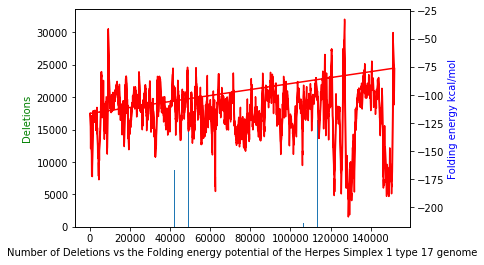

In [39]:
import pandas as pd

df=pd.read_csv('Dummy_deletions_window.csv')
df3=pd.read_csv('local_foldE_500.csv')

middle_list = df.middle.tolist()
Deletions_list = df.Deletions.tolist()
foldE_list= df3.folding_energy_potential.tolist()
x=middle_list
y=Deletions_list
y1=foldE_list

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.bar(x, y)
ax2.plot(x, y1, '-', color="red" )

ax1.set_xlabel('Number of Deletions vs the Folding energy potential of the Herpes Simplex 1 type 17 genome')
ax1.set_ylabel('Deletions', color='g')
ax2.set_ylabel('Folding energy kcal/mol', color='b')

In a real life example, predicted secondary DNA structures might be found in regions where the folding energy potential is the most negative. And within these regions there should be a greater amount of deletions.

I encourage you to test your results experimentally to validate the presence of this structures within your chosen genome.